In [ ]:
import os
import torch
from torchvision.utils.data import DataLoader
from torchvision import transforms
from torch import optim
from torch import nn

In [ ]:
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir,test_dir

In [ ]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.1),
    transforms.ToTensor()
])

In [494]:
from torchvision.datasets import ImageFolder

train_data = ImageFolder(root=train_dir,
                         transform=data_transform)
test_data = ImageFolder(root=test_dir,
                        transform=data_transform)

In [502]:
train_dataloader = DataLoader(train_data,batch_size=32,shuffle=True)
test_dataloader = DataLoader(test_data,batch_size=32)

train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7a2668de08d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7a2668e9e4d0>)

In [503]:
print(f"Length of train data: {len(train_data)} and test data: {len(test_data)}")
print(f"Length of train dataloader: {len(train_dataloader)} and test dataloader: {len(test_dataloader)}")

Length of train data: 225 and test data: 75
Length of train dataloader: 8 and test dataloader: 3


In [504]:
img,target = next(iter(train_dataloader))
print(f"Image Shape: {img.shape} -> [batch_size,colour_channel,height,width]")
print(f"Target Shape: {target.shape}")

Image Shape: torch.Size([32, 3, 64, 64]) -> [batch_size,colour_channel,height,width]
Target Shape: torch.Size([32])


In [505]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Base Model -> TinyVGG

In [506]:
simple_data_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

train_data_simple = ImageFolder(
    root=train_dir,
    transform = simple_data_transform
)

test_data_simple = ImageFolder(
    root=test_dir,
    transform = simple_data_transform
)

In [ ]:
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_data_simple_dataloader = DataLoader(dataset=train_data_simple,
                                          batch_size=BATCH_SIZE,
                                          num_workers=NUM_WORKERS,
                                          shuffle=True)
test_data_simple_dataloader = DataLoader(dataset=test_data_simple,
                                          batch_size=BATCH_SIZE,
                                          num_workers=NUM_WORKERS,
                                          shuffle=False)

In [508]:
from torch import nn

class TinyVGG(nn.Module):
    def __init__(self, input_units, hidden_units, output_units):
        super().__init__()

        # First conv block
        self.conv_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_units,
                out_channels=hidden_units,
                kernel_size=3,
                padding=0,
                stride=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Second conv block
        self.conv_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                padding=0,
                stride=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_3 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                padding=0,
                stride=1
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=0
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*4*4,
                      out_features=output_units)
        )

    def forward(self, x: nn.Module):
        x = self.conv_1(x)
        # print("After conv_1:", x.shape)
        x = self.conv_2(x)
        # print("After conv_2:", x.shape)
        x = self.conv_3(x)
        # print("After con_3:", x.shape)
        x = self.classifier(x)
        # print("After classifier:", x.shape)
        return x


In [509]:
torch.manual_seed(42)
model_0 = TinyVGG(input_units=3,
                  hidden_units=64,
                  output_units=len(class_names)
                  ).to(device)
# print(model_0)

In [510]:
image_batch, target_batch = next(iter(train_data_simple_dataloader))
print(target_batch)

tensor([1, 1, 0, 0, 0, 0, 0, 2, 1, 1, 1, 2, 1, 1, 1, 0, 0, 2, 0, 0, 1, 1, 1, 2,
        1, 1, 1, 1, 2, 2, 2, 1])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x2560 and 10x3)

256 should be multiplied to 10 in forward method

In [511]:
# model_0(image_batch.to(device))

In [512]:
%pip install torchinfo

In [513]:
from torchinfo import summary
summary(model_0)

Layer (type:depth-idx)                   Param #
TinyVGG                                  --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       1,792
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       36,928
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-6                       36,928
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       36,928
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
├─Sequential: 1-3                        --
│    └─Conv2d: 2-11                      36,928
│    └─ReLU: 2-12                        --
│    └─Conv2d: 2-13                      36,928
│    └─ReLU: 2-14                        --
│    └─MaxPool2d: 2-15                   --
├─Sequential: 1-4                        --
│    └─Flatten: 2-16                     --
│   

In [514]:
from torch import optim
EPOCHS = 20
LR = 0.001
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_0.parameters(),lr=LR)

In [515]:
from tqdm.auto import tqdm

def train_step(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device
):
    """Train the model for one epoch."""
    model.train()
    train_loss, correct_preds = 0, 0

    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accuracy
        y_pred_class = torch.argmax(y_pred, dim=1)
        correct_preds += (y_pred_class == y).sum().item()

    train_loss /= len(data_loader)
    train_acc = correct_preds / len(data_loader.dataset) # type: ignore

    print(f"Train Loss: {train_loss:.3f} | Train Acc: {train_acc:.3f}")
    return train_loss,train_acc


def test_step(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device: torch.device
):
    """Evaluate the model on the test dataset."""
    model.eval()
    test_loss, correct_preds = 0, 0

    with torch.inference_mode():
        for batch, (X_t, y_t) in enumerate(data_loader):
            X_t, y_t = X_t.to(device), y_t.to(device)

            test_logits = model(X_t)
            loss = loss_fn(test_logits, y_t)
            test_loss += loss.item()

            test_logits_class = torch.argmax(test_logits, dim=1)
            correct_preds += (test_logits_class == y_t).sum().item()

    test_loss /= len(data_loader)
    test_acc = correct_preds / len(data_loader.dataset) # type: ignore

    print(f"Test Loss: {test_loss:.3f} | Test Acc: {test_acc:.3f}")
    return test_loss,test_acc

In [516]:
from tqdm.auto import tqdm
import torch
from typing import Optional

def train(
    num_epochs: int,
    model: torch.nn.Module,
    train_loader: torch.utils.data.DataLoader,
    test_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
):
    """Run training + testing for multiple epochs."""
    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
    }

    for epoch in tqdm(range(num_epochs)):
        print(f"\nEpoch {epoch+1}/{num_epochs}")

        # Training
        train_loss, train_acc = train_step(
            model=model,
            data_loader=train_loader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device,
        )

        # Testing
        test_loss, test_acc = test_step(
            model=model,
            data_loader=test_loader,
            loss_fn=loss_fn,
            device=device,
        )

        # Save results
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results


In [517]:
model_0_results  = train(num_epochs=EPOCHS,
      model=model_0,
      train_loader=train_data_simple_dataloader,
      test_loader=test_data_simple_dataloader,
      loss_fn=loss_fn,
      optimizer=optimizer,
      device=device)

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 1/20
Train Loss: 1.104 | Train Acc: 0.329
Test Loss: 1.107 | Test Acc: 0.333

Epoch 2/20
Train Loss: 1.088 | Train Acc: 0.333
Test Loss: 1.136 | Test Acc: 0.253

Epoch 3/20
Train Loss: 1.091 | Train Acc: 0.333
Test Loss: 1.134 | Test Acc: 0.253

Epoch 4/20
Train Loss: 1.109 | Train Acc: 0.333
Test Loss: 1.145 | Test Acc: 0.253

Epoch 5/20
Train Loss: 1.043 | Train Acc: 0.333
Test Loss: 1.148 | Test Acc: 0.253

Epoch 6/20
Train Loss: 1.025 | Train Acc: 0.347
Test Loss: 1.061 | Test Acc: 0.293

Epoch 7/20
Train Loss: 0.953 | Train Acc: 0.387
Test Loss: 1.076 | Test Acc: 0.413

Epoch 8/20
Train Loss: 0.946 | Train Acc: 0.604
Test Loss: 1.033 | Test Acc: 0.480

Epoch 9/20
Train Loss: 1.004 | Train Acc: 0.542
Test Loss: 1.043 | Test Acc: 0.440

Epoch 10/20
Train Loss: 0.819 | Train Acc: 0.609
Test Loss: 0.960 | Test Acc: 0.493

Epoch 11/20
Train Loss: 0.957 | Train Acc: 0.627
Test Loss: 1.206 | Test Acc: 0.427

Epoch 12/20
Train Loss: 0.952 | Train Acc: 0.640
Test Loss: 1.016 | Test 

In [518]:
from typing import Dict,List
def plot_loss_curves(results:Dict[str,List[float]]):
  """ Plots training curves of a results dictionary """
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  train_acc = results["train_acc"]
  test_acc = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  plt.figure(figsize=(15,4))
  plt.subplot(1,2,1)
  plt.plot(epochs,loss,label="train_loss")
  plt.plot(epochs,test_loss,label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(epochs,train_acc,label="train_accuracy")
  plt.plot(epochs,test_acc,label="test accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

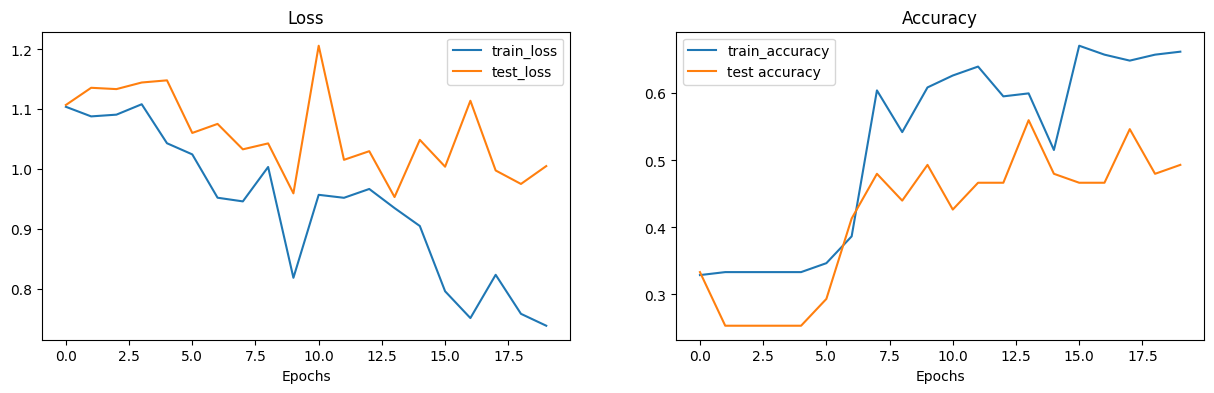

In [519]:
plot_loss_curves(model_0_results)

# TinyVGG with Data Augmentaton

In [520]:
train_transform_trivial = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # 0 to 31
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [521]:
train_data_simple_augment=  ImageFolder(root=train_dir,
                                        transform=train_transform_trivial)
test_data_simple_augment = ImageFolder(root=test_dir,
                                       transform=test_transform_simple)

In [522]:
train_data_simple_augment_dataloader= DataLoader(
                                              dataset=train_data_simple_augment,
                                              shuffle=True,
                                              batch_size=BATCH_SIZE,
                                              num_workers=NUM_WORKERS)

test_data_simple_augment_dataloader = DataLoader(
    dataset=test_data_simple_augment,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS
    )

In [523]:
len((next(iter(train_data_simple_augment_dataloader)))[0])

32

In [524]:
model_1 = TinyVGG(input_units=3,
                  hidden_units=64,
                  output_units=len(class_names))
# print(model_1)

In [525]:
LR = 0.001
optimizer = optim.Adam(model_1.parameters(),lr=LR)
loss_fn = nn.CrossEntropyLoss()

In [526]:
model_1_results = train(num_epochs=20,
                        model=model_1,
                        train_loader=train_data_simple_augment_dataloader,
                        test_loader=test_data_simple_augment_dataloader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        device=device)
# model_1_results

  0%|          | 0/20 [00:00<?, ?it/s]


Epoch 1/20
Train Loss: 1.100 | Train Acc: 0.333
Test Loss: 1.084 | Test Acc: 0.360

Epoch 2/20
Train Loss: 1.055 | Train Acc: 0.409
Test Loss: 1.147 | Test Acc: 0.253

Epoch 3/20
Train Loss: 1.054 | Train Acc: 0.378
Test Loss: 1.036 | Test Acc: 0.347

Epoch 4/20
Train Loss: 1.076 | Train Acc: 0.422
Test Loss: 1.113 | Test Acc: 0.387

Epoch 5/20
Train Loss: 1.037 | Train Acc: 0.484
Test Loss: 1.072 | Test Acc: 0.387

Epoch 6/20
Train Loss: 1.038 | Train Acc: 0.476
Test Loss: 1.088 | Test Acc: 0.387

Epoch 7/20
Train Loss: 0.977 | Train Acc: 0.498
Test Loss: 1.069 | Test Acc: 0.360

Epoch 8/20
Train Loss: 0.952 | Train Acc: 0.493
Test Loss: 1.059 | Test Acc: 0.360

Epoch 9/20
Train Loss: 0.899 | Train Acc: 0.524
Test Loss: 1.049 | Test Acc: 0.360

Epoch 10/20
Train Loss: 1.023 | Train Acc: 0.484
Test Loss: 1.081 | Test Acc: 0.427

Epoch 11/20
Train Loss: 1.035 | Train Acc: 0.511
Test Loss: 1.031 | Test Acc: 0.480

Epoch 12/20
Train Loss: 1.021 | Train Acc: 0.493
Test Loss: 0.977 | Test 

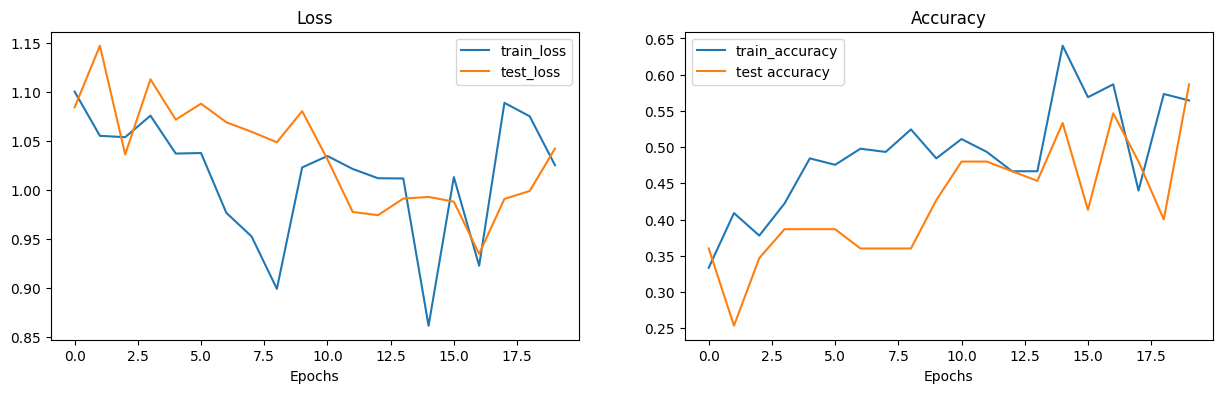

In [527]:
plot_loss_curves(model_1_results)

In [528]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)

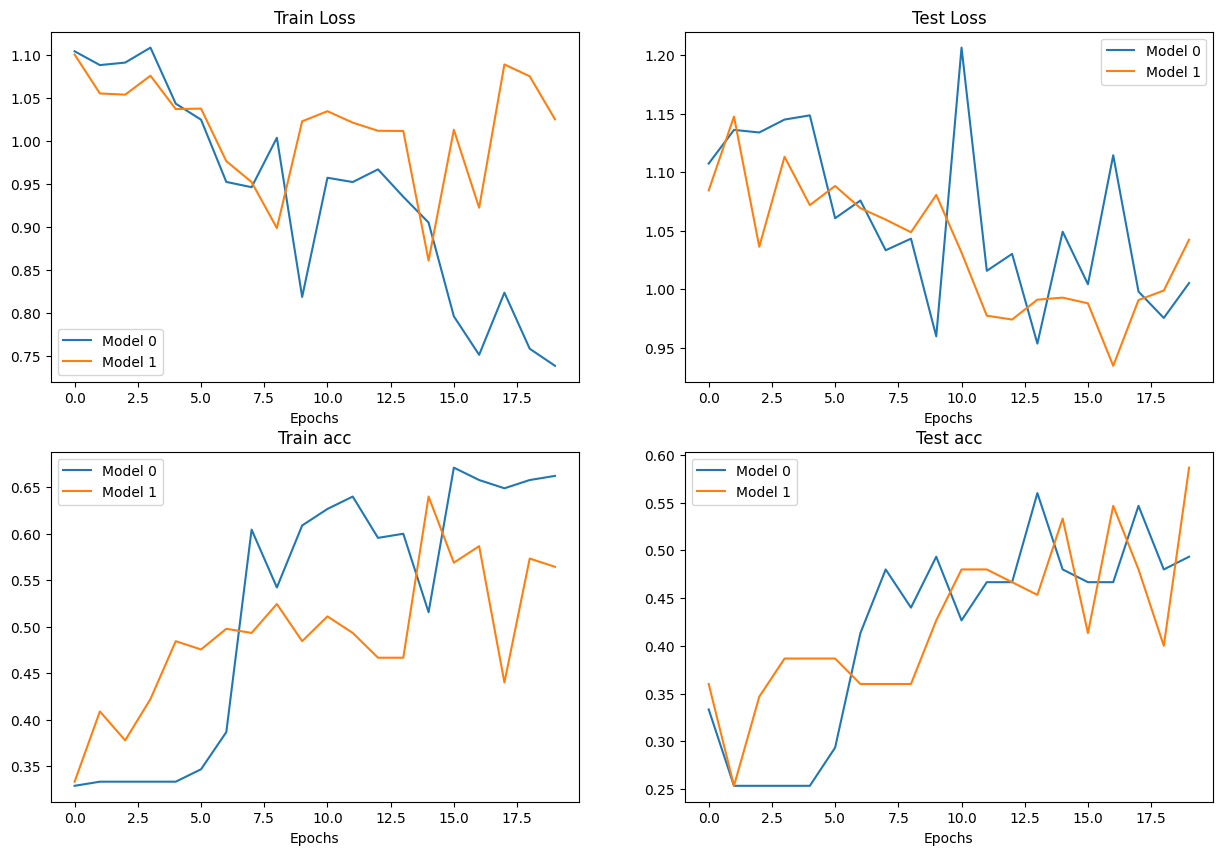

In [529]:
plt.figure(figsize=(15,10))

epochs = range(len(model_0_df))
plt.subplot(2,2,1)
plt.plot(epochs,model_0_df["train_loss"],label="Model 0")
plt.plot(epochs,model_1_df["train_loss"],label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend();

plt.subplot(2,2,2)
plt.plot(epochs,model_0_df["test_loss"],label="Model 0")
plt.plot(epochs,model_1_df["test_loss"],label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend();

plt.subplot(2,2,3)
plt.plot(epochs,model_0_df["train_acc"],label="Model 0")
plt.plot(epochs,model_1_df["train_acc"],label="Model 1")
plt.title("Train acc")
plt.xlabel("Epochs")
plt.legend();

plt.subplot(2,2,4)
plt.plot(epochs,model_0_df["test_acc"],label="Model 0")
plt.plot(epochs,model_1_df["test_acc"],label="Model 1")
plt.title("Test acc")
plt.xlabel("Epochs")
plt.legend();

## Loading a custom image

In [530]:
import requests

response = requests.get("https://images8.alphacoders.com/369/369063.jpg")

with open("custom_image.jpg","wb") as f:
  f.write(response.content)

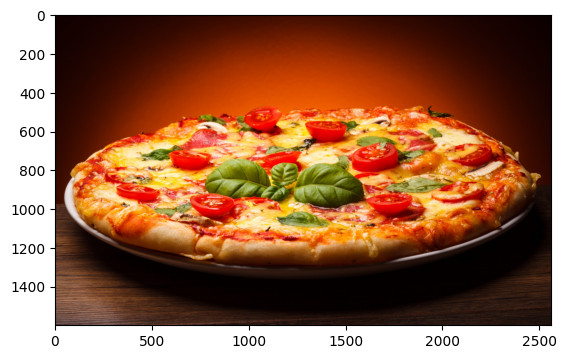

In [531]:
import torchvision
custom_image_path = "custom_image.jpg"
custom_image_units = torchvision.io.read_image(custom_image_path)
plt.imshow(custom_image_units.permute(1,2,0))

In [532]:
# print(f"Custom image tensor:\n{custom_image_units}")
print(f"Custom image shape: {custom_image_units.shape}")
print(f"Custom image device: {custom_image_units.device}")
print(f"Custom image dtype: {custom_image_units.dtype}")

Custom image shape: torch.Size([3, 1600, 2560])
Custom image device: cpu
Custom image dtype: torch.uint8


In [533]:
custom_image = custom_image_units.type(torch.float32).to(device) / 255

In [534]:
custom_image_transform = transforms.Compose([
    transforms.Resize((64,64))
])

custom_image_transformed = custom_image_transform(custom_image)

In [535]:
print(f"Original Shape: {custom_image_units.shape}")
print(f"Transformed Shape: {custom_image_transformed.shape}")
print(f"Adding Batch: {custom_image_transformed.unsqueeze(0).shape}")

Original Shape: torch.Size([3, 1600, 2560])
Transformed Shape: torch.Size([3, 64, 64])
Adding Batch: torch.Size([1, 3, 64, 64])


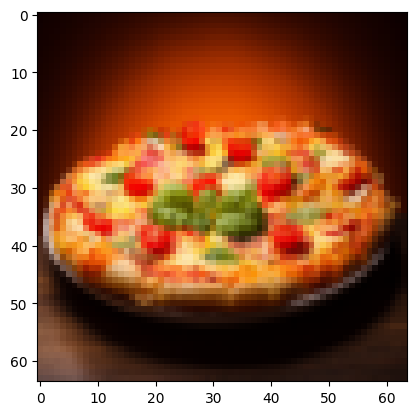

In [536]:
plt.imshow(custom_image_transformed.permute(1,2,0))

In [537]:
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(0))

In [538]:
custom_image_pred

tensor([[ 0.0624, -0.1876,  0.0537]])

In [539]:
class_names[custom_image_pred.argmax(dim=1)]

'pizza'

In [540]:
def custom_image_predictions(img_path:str,
                             model: torch.nn.Module,
                             device:torch.device,
                             class_names:list[str],
                             transform: None):
  """ Used to predict custom images to test the model """
  target_image = torchvision.io.read_image(img_path)
  target_image = target_image.type(torch.float32).to(device) / 255
  if transform:
    target_image = transform(target_image)
  target_image = target_image.unsqueeze(0)
  model.eval()
  with torch.inference_mode():
    target_img_pred = model(target_image)
  target = target_img_pred.argmax(dim=1)
  plt.imshow(target_image.squeeze().permute(1,2,0))
  return class_names[target]

'pizza'

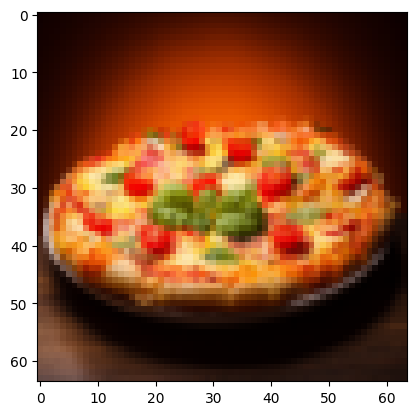

In [541]:
custom_image_predictions(img_path=custom_image_path,
                         model=model_1,
                         transform=custom_image_transform,
                         device=device,
                         class_names=class_names)